In [50]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import pyVIA.core as via
#print('pyVIA(Ver): ',via.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.5.3
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.7


In [51]:
from pyVIA.utils_via import *
from pyVIA.plotting_via import *
def draw_piechart_graph(adata,clusters,via_object, type_data='pt', gene_exp:list=[], title='', cmap:str=None, ax_text=True, dpi=150,headwidth_arrow = 0.1, alpha_edge=0.4, linewidth_edge=2, edge_color='darkblue',reference=None, show_legend:bool=True, pie_size_scale:float=0.8, fontsize:float=8):
    '''
    plot two subplots with a clustergraph level representation of the viagraph showing true-label composition (lhs) and pseudotime/gene expression (rhs)
    Returns matplotlib figure with two axes that plot the clustergraph using edge bundling
    left axis shows the clustergraph with each node colored by annotated ground truth membership.
    right axis shows the same clustergraph with each node colored by the pseudotime or gene expression
    :param via_object: is class VIA (the same function also exists as a method of the class and an external plotting function
    :param type_data: string  default 'pt' for pseudotime colored nodes. or 'gene'
    :param gene_exp: list of values (column of dataframe) corresponding to feature or gene expression to be used to color nodes at CLUSTER level
    :param title: string
    :param cmap: default None. automatically chooses coolwarm for gene expression or viridis_r for pseudotime
    :param ax_text: Bool default= True. Annotates each node with cluster number and population of membership
    :param dpi: int default = 150
    :param headwidth_bundle: default = 0.1. width of arrowhead used to directed edges
    :param reference: None or list. list of categorical (str) labels for cluster composition of the piecharts (LHS subplot) length = n_samples.
    :param pie_size_scale: float default=0.8 scaling factor of the piechart nodes
    :return: f, ax, ax1
    '''

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    f, ((ax, ax1)) = plt.subplots(1, 2, sharey=True, dpi=dpi)

    node_pos = via_object.graph_node_pos

    node_pos = np.asarray(node_pos)
    if cmap is None: cmap = 'coolwarm' if type_data == 'gene' else 'viridis_r'

    if type_data == 'pt':
        pt = via_object.scaled_hitting_times  # these are the final MCMC refined pt then slightly scaled at cluster level
        title_ax1 = "Pseudotime"

    if type_data == 'gene':
        pt = gene_exp
        title_ax1 = title
    if reference is None: reference_labels=via_object.true_label
    else: reference_labels = reference
    n_groups = len(set(via_object.labels))
    n_truegroups = len(set(reference_labels))
    group_pop = np.zeros([n_groups, 1])
    group_frac = pd.DataFrame(np.zeros([n_groups, n_truegroups]), columns=list(adata.obs[clusters].cat.categories))
    via_object.cluster_population_dict = {}
    for group_i in set(via_object.labels):
        loc_i = np.where(via_object.labels == group_i)[0]

        group_pop[group_i] = len(loc_i)  # np.sum(loc_i) / 1000 + 1
        via_object.cluster_population_dict[group_i] = len(loc_i)
        true_label_in_group_i = list(np.asarray(reference_labels)[loc_i])
        for ii in set(true_label_in_group_i):
            group_frac[ii][group_i] = true_label_in_group_i.count(ii)

    line_true = np.linspace(0, 1, n_truegroups)
    color_true_list = [plt.cm.rainbow(color) for color in line_true]
    color_true_list=adata.uns['{}_colors'.format(clusters)]

    sct = ax.scatter(node_pos[:, 0], node_pos[:, 1],
                     c='white', edgecolors='face', s=group_pop, cmap='jet')

    bboxes = getbb(sct, ax)

    ax = plot_edgebundle_viagraph(ax, via_object.hammerbundle_cluster, layout=via_object.graph_node_pos, CSM=via_object.CSM,
                            velocity_weight=via_object.velo_weight, pt=pt, headwidth_bundle=headwidth_arrow,
                            alpha_bundle=alpha_edge,linewidth_bundle=linewidth_edge, edge_color=edge_color)

    trans = ax.transData.transform
    bbox = ax.get_position().get_points()
    ax_x_min = bbox[0, 0]
    ax_x_max = bbox[1, 0]
    ax_y_min = bbox[0, 1]
    ax_y_max = bbox[1, 1]
    ax_len_x = ax_x_max - ax_x_min
    ax_len_y = ax_y_max - ax_y_min
    trans2 = ax.transAxes.inverted().transform
    pie_axs = []
    pie_size_ar = ((group_pop - np.min(group_pop)) / (np.max(group_pop) - np.min(group_pop)) + 0.5) / 10  # 10

    for node_i in range(n_groups):

        cluster_i_loc = np.where(np.asarray(via_object.labels) == node_i)[0]
        majority_true = via_object.func_mode(list(np.asarray(reference_labels)[cluster_i_loc]))
        pie_size = pie_size_ar[node_i][0] *pie_size_scale

        x1, y1 = trans(node_pos[node_i])  # data coordinates
        xa, ya = trans2((x1, y1))  # axis coordinates

        xa = ax_x_min + (xa - pie_size / 2) * ax_len_x
        ya = ax_y_min + (ya - pie_size / 2) * ax_len_y
        # clip, the fruchterman layout sometimes places below figure
        if ya < 0: ya = 0
        if xa < 0: xa = 0
        rect = [xa, ya, pie_size * ax_len_x, pie_size * ax_len_y]
        frac = np.asarray([ff for ff in group_frac.iloc[node_i].values])

        pie_axs.append(plt.axes(rect, frameon=False))
        pie_axs[node_i].pie(frac, wedgeprops={'linewidth': 0.0}, colors=color_true_list)
        pie_axs[node_i].set_xticks([])
        pie_axs[node_i].set_yticks([])
        pie_axs[node_i].set_aspect('equal')
        # pie_axs[node_i].text(0.5, 0.5, graph_node_label[node_i])
        if ax_text==True: pie_axs[node_i].text(0.5, 0.5, majority_true, fontsize = fontsize )

    patches, texts = pie_axs[node_i].pie(frac, wedgeprops={'linewidth': 0.0}, colors=color_true_list)
    labels = list(set(reference_labels))
    if show_legend ==True: plt.legend(patches, labels, loc=(-5, -5), fontsize=6, frameon=False)

    if via_object.time_series==True:
        ti = 'Cluster Composition. K=' + str(via_object.knn) + '. ncomp = ' + str(via_object.ncomp)  +'knnseq_'+str(via_object.knn_sequential)# "+ is_sub
    else:
        ti = 'Cluster Composition. K=' + str(via_object.knn) + '. ncomp = ' + str(via_object.ncomp)
    ax.set_title(ti)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    title_list = [title_ax1]
    for i, ax_i in enumerate([ax1]):
        pt = via_object.markov_hitting_times if type_data == 'pt' else gene_exp

        c_edge, l_width = [], []
        for ei, pti in enumerate(pt):
            if ei in via_object.terminal_clusters:
                c_edge.append('red')
                l_width.append(1.5)
            else:
                c_edge.append('gray')
                l_width.append(0.0)

        gp_scaling = 1000 / max(group_pop)

        group_pop_scale = group_pop * gp_scaling * 0.5
        ax_i=plot_edgebundle_viagraph(ax_i, via_object.hammerbundle_cluster, layout=via_object.graph_node_pos,CSM=via_object.CSM, velocity_weight=via_object.velo_weight, pt=pt,headwidth_bundle=headwidth_arrow, alpha_bundle=alpha_edge, linewidth_bundle=linewidth_edge, edge_color=edge_color)

        im1 = ax_i.scatter(node_pos[:, 0], node_pos[:, 1], s=group_pop_scale, c=pt, cmap=cmap,
                           edgecolors=c_edge,
                           alpha=1, zorder=3, linewidth=l_width)
        if ax_text:
            x_max_range = np.amax(node_pos[:, 0]) / 100
            y_max_range = np.amax(node_pos[:, 1]) / 100

            for ii in range(node_pos.shape[0]):
                ax_i.text(node_pos[ii, 0] + max(x_max_range, y_max_range),
                          node_pos[ii, 1] + min(x_max_range, y_max_range),
                          'C' + str(ii) + 'pop' + str(int(group_pop[ii][0])),
                          color='black', zorder=4, fontsize = fontsize)
        ax_i.set_title(title_list[i])
        ax_i.grid(False)
        ax_i.set_xticks([])
        ax_i.set_yticks([])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    if type_data == 'pt':
        f.colorbar(im1, cax=cax, orientation='vertical', label='pseudotime',shrink=0.5)
    else:
        f.colorbar(im1, cax=cax, orientation='vertical', label='Gene expression',shrink=0.5)
    f.patch.set_visible(False)

    ax1.axis('off')
    ax.axis('off')
    ax.set_facecolor('white')
    ax1.set_facecolor('white')
    return f, ax, ax1

In [52]:
rna=sc.read('/home/leihu/data/analysis/rb_tutorial/data/analysis1/rna_anno.h5ad')
rna

AnnData object with n_obs × n_vars = 20105 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'dendrogram_leiden', 'dendrogram_

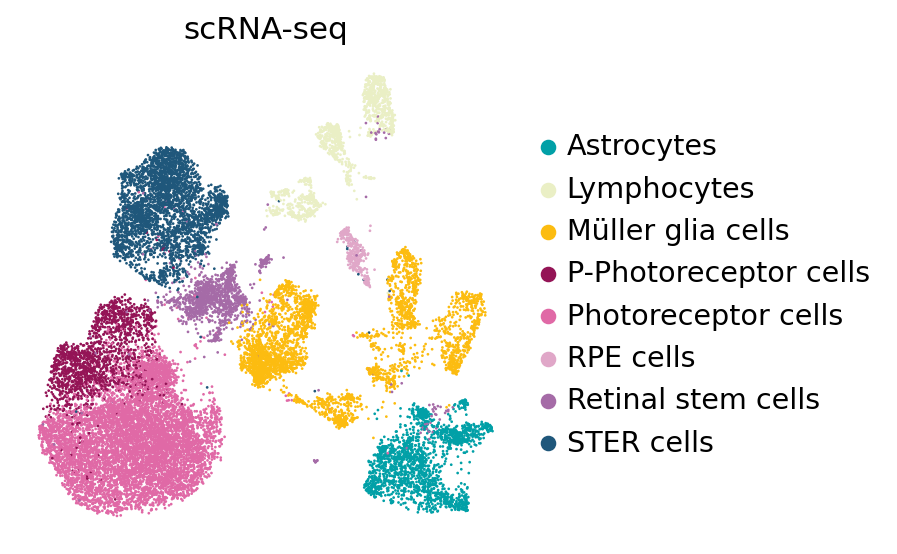

In [53]:
ax=sc.pl.embedding(
    rna,
    basis="X_umap",
    color=['major_celltype'],
    title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)
plt.savefig('result_4/all_celltype1.png',dpi=300,bbox_inches='tight')

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_major_celltype']`


[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

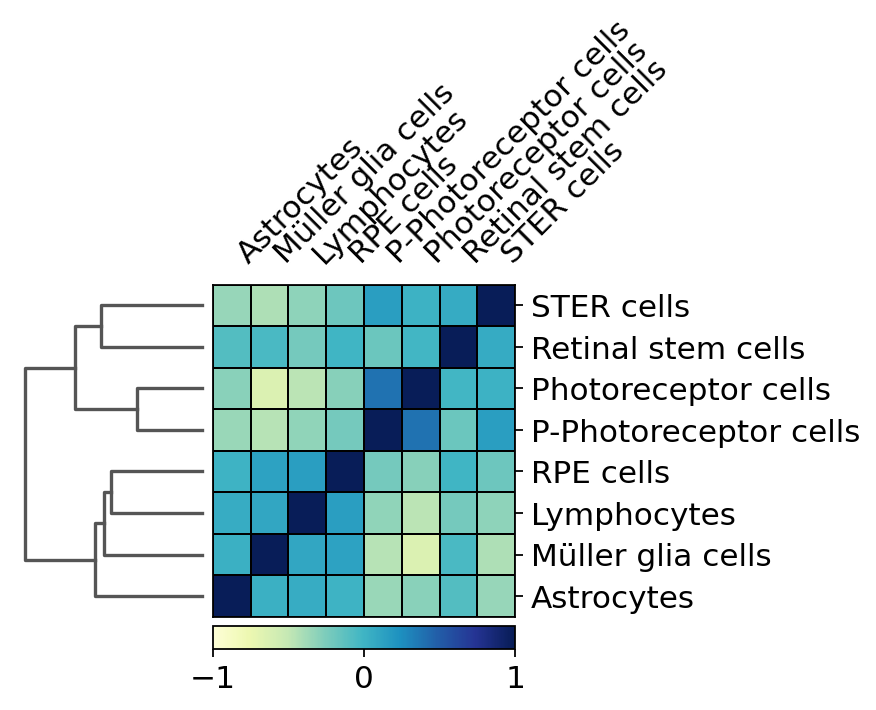

In [55]:
sc.tl.dendrogram(rna,'major_celltype')
sc.pl.correlation_matrix(rna, 'major_celltype', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         )
#plt.suptitle('RNA Activity',fontsize=14,x=0.75,y=0,horizontalalignment='center')
#plt.savefig(current_path+'result/analysis1/act_correlation.png',dpi=300,bbox_inches='tight')

Storing dendrogram info using `.uns['dendrogram_major_celltype']`


[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

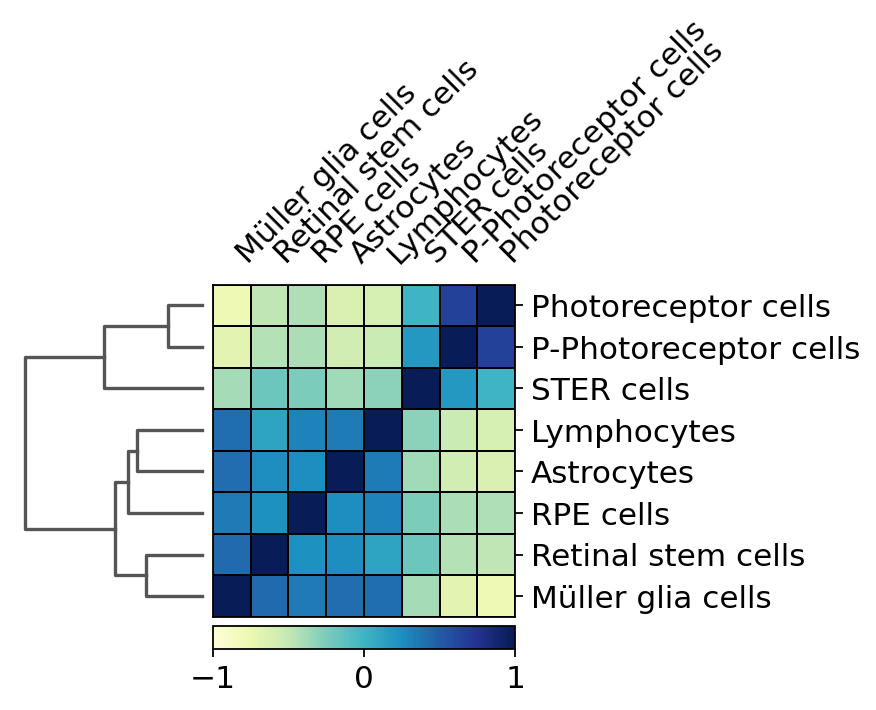

In [56]:
sc.tl.dendrogram(rna,'major_celltype',use_rep='X')
sc.pl.correlation_matrix(rna, 'major_celltype', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         )
#plt.suptitle('Motif Score',fontsize=14,x=0.75,y=0,horizontalalignment='center')
#plt.savefig(current_path+'result/analysis1/motif_correlation.png',dpi=300,bbox_inches='tight')

Storing dendrogram info using `.uns['dendrogram_major_celltype']`


[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

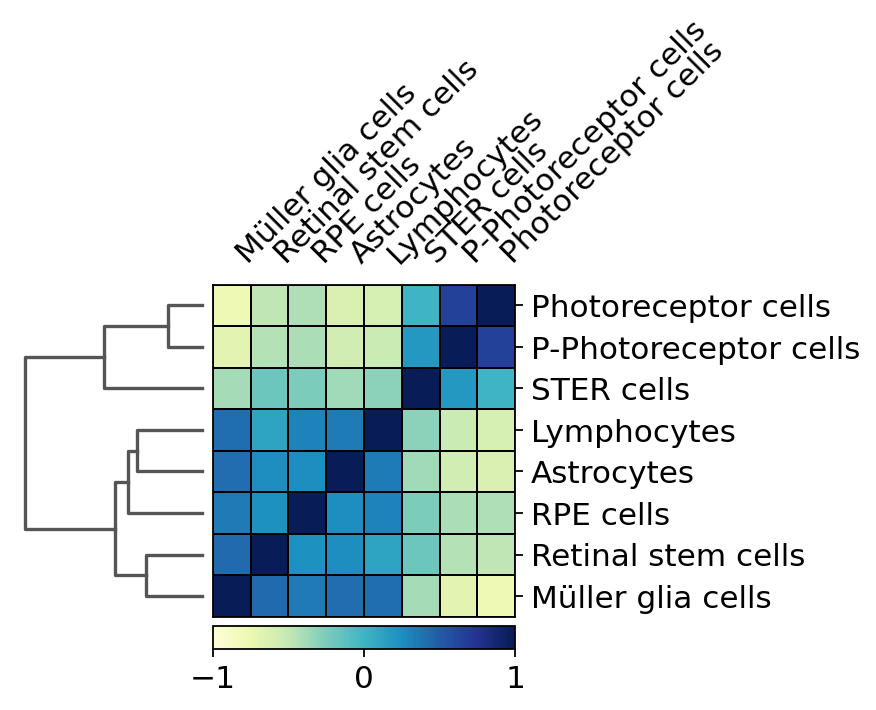

In [57]:
sc.tl.dendrogram(rna,'major_celltype',use_rep='X')
sc.pl.correlation_matrix(rna, 'major_celltype', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         )
#plt.suptitle('RNA Expression',fontsize=14,x=0.75,y=0,horizontalalignment='center')
#plt.savefig(current_path+'result/analysis1/RNA_correlation.png',dpi=300,bbox_inches='tight')

In [59]:

adata_atac=sc.read('data/atac_anno_new.h5ad')
adata_atac

AnnData object with n_obs × n_vars = 21194 × 296334
    obs: 'Tissue', 'Developmental_Stage', 'SRR', 'nb_features', 'log_nb_features', 'domain', 'balancing_weight', 'leiden', 'major_celltype', 'major_celltype_new'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score', 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
    uns: 'Developmental_Stage_colors', 'SRR_colors', '__scglue__', 'leiden', 'leiden_colors', 'major_celltype_colors', 'major_celltype_new_colors', 'neighbors', 'umap'
    obsm: 'X_glue', 'X_lsi', 'X_umap'
    varm: 'X_glue'
    obsp: 'connectivities', 'distances'

In [60]:
sc.tl.dendrogram(adata_act,'major_celltype')
sc.pl.correlation_matrix(adata_act, 'major_celltype', 
                         figsize=(4,3),
                         cmap='YlGnBu',
                         dendrogram=True,
                         show=False,
                         )

NameError: name 'adata_act' is not defined

In [5]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Photoreceptor cells',
     '1': 'Photoreceptor cells',
     '2': 'Müller glia cells',#Germ-cell(Oid)
     '3': 'Photoreceptor cells',#Germ-cell(Oid)
     '4': 'STER cells',
     '5': 'Astrocytes',
     '6': 'Retinal stem cells',
     '7': 'Photoreceptor progenitor cell',
     '8': 'STER cells',
     '9': 'Photoreceptor cells',
     '10': 'Astrocytes',#Germ-cell(Oid)
     '11': 'Photoreceptor progenitor cell',
     '12': 'Müller glia cells',
     '13': 'Müller glia cells',
     '14': 'Müller glia cells',
     '15': 'STER cells',#Germ
     '16': 'Photoreceptor cells',#plasma
     '17': 'Lymphocytes',#plasma
     '18': 'Müller glia cells',
     '19': 'Müller glia cells',
     '20': 'Retinal pigment epithelium (RPE) cells',#Germ-cell(Oid)
     '21': 'STER cells',
     '22': 'Müller glia cells',
     '23': 'Müller glia cells',



}
rna.obs['major_celltype'] = rna.obs['leiden'].map(cluster2annotation).astype('category')

In [6]:
rna.obs['major_celltype_new']=rna.obs['major_celltype']
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('str')
rna.obs.loc[rna.obs['major_celltype']=='Retinal pigment epithelium (RPE) cells','major_celltype_new']='RPE cells'
rna.obs.loc[rna.obs['major_celltype']=='Retinal progenitor cells (RPCs)','major_celltype_new']='RPCs'
rna.obs.loc[rna.obs['major_celltype']=='Photoreceptor progenitor cell','major_celltype_new']='P-Photoreceptor cells'
rna.obs['major_celltype_new']=rna.obs['major_celltype_new'].astype('category')

In [7]:
rna.obs['major_celltype_new'].unique()

['Müller glia cells', 'Photoreceptor cells', 'Astrocytes', 'STER cells', 'Lymphocytes', 'RPE cells', 'Retinal stem cells', 'P-Photoreceptor cells']
Categories (8, object): ['Astrocytes', 'Lymphocytes', 'Müller glia cells', 'P-Photoreceptor cells', 'Photoreceptor cells', 'RPE cells', 'Retinal stem cells', 'STER cells']

In [8]:
adata=rna[rna.obs['major_celltype_new'].isin(['Müller glia cells', 'Astrocytes','Lymphocytes','RPE cells'])]
adata

View of AnnData object with n_obs × n_vars = 6677 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw', 'major_celltype_new'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'den

In [9]:
sc.tl.pca(adata, n_comps=100, svd_solver="arpack")

#scv.pl.velocity_embedding_stream(adata, basis='umap',color=['major_celltype','leiden','Type'])

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:03)


In [10]:
sc.pp.neighbors(adata, use_rep="X_pca", metric="cosine",n_neighbors=100, random_state = 112)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga')
#sc.pl.umap(adata,color='leiden')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


In [11]:
adata.obs['leiden'].value_counts()[adata.obs['leiden'].value_counts()<100].index

CategoricalIndex(['12', '13'], categories=['0', '1', '2', '3', ..., '10', '11', '12', '13'], ordered=False, dtype='category')

In [12]:
adata=adata[~adata.obs['leiden'].isin(adata.obs['leiden'].value_counts()[adata.obs['leiden'].value_counts()<100].index)]
adata

View of AnnData object with n_obs × n_vars = 6614 × 2000
    obs: 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Tissue', 'Developmental_Stage', 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'domain', 'leiden', 'balancing_weight', 'n_counts', 'major_celltype', 'obs_index_raw', 'major_celltype_new'
    var: 'gene_ids', 'feature_types', 'genome', 'Accession', 'End', 'Start', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'ID', 'copy_num_ID', 'coverage', 'db_xref', 'extra_copy_number', 'gbkey', 'gene', 'gene_biotype', 'gene_name', 'dell', 'dispersions', 'dispersions_norm'
    uns: 'Developmental_Stage_colors', '__scglue__', 'cosg', 'den

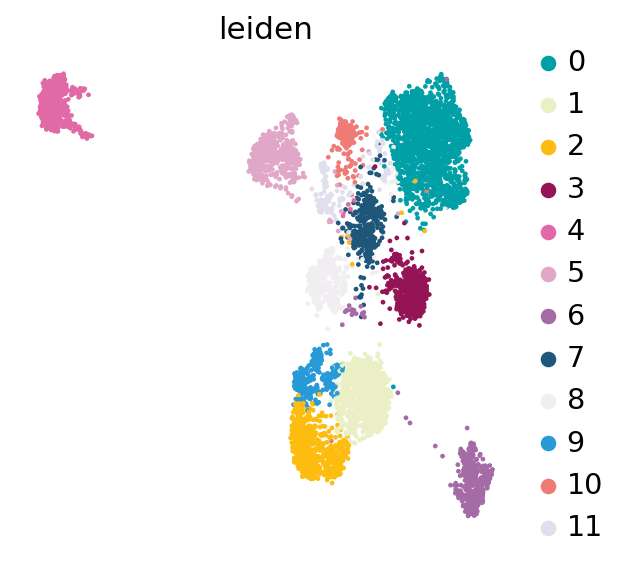

In [13]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['leiden'],
    title='leiden',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)
plt.savefig('result_4/leiden.png',dpi=300,bbox_inches='tight')

In [14]:
scv.tl.recover_dynamics(adata,n_jobs=10)

recovering dynamics (using 10/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [15]:
scv.tl.velocity(adata, mode='dynamical',show_progress_bar=False)
scv.tl.velocity_graph(adata,n_jobs=10)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/12 cores)
    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


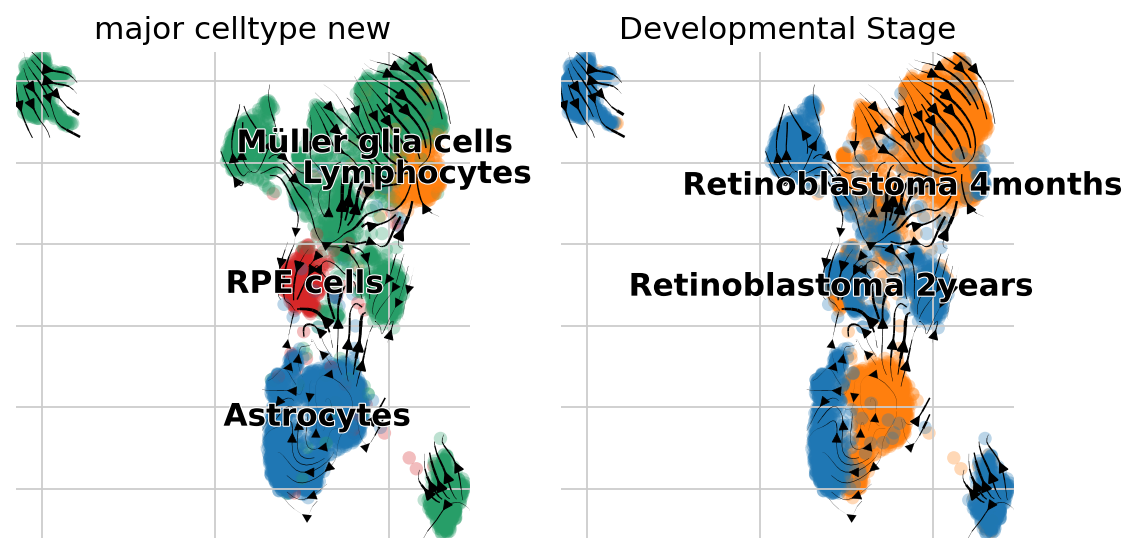

In [16]:
scv.pl.velocity_embedding_stream(adata, basis='umap',color=['major_celltype_new','Developmental_Stage'])

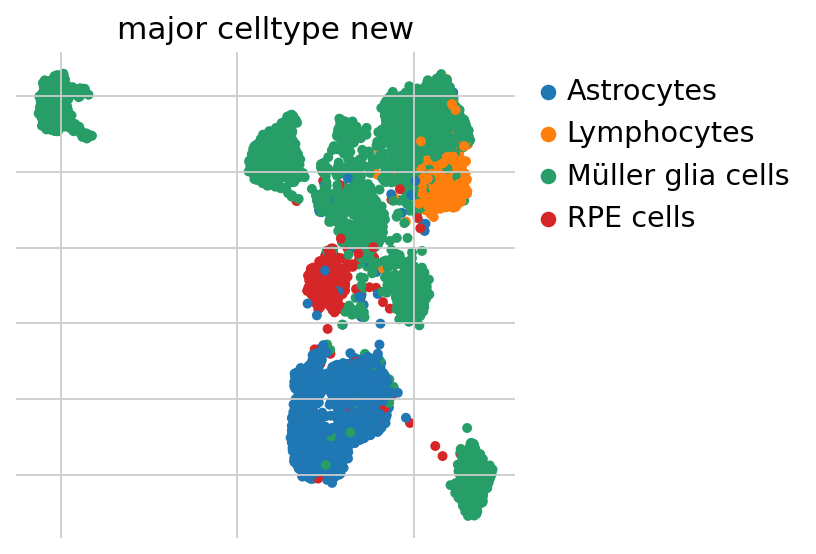

In [17]:
scv.pl.scatter(adata, color='major_celltype_new', color_map='pink',show=False, size=80)
plt.savefig('result_4/all_celltype.png',dpi=300,bbox_inches='tight')

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


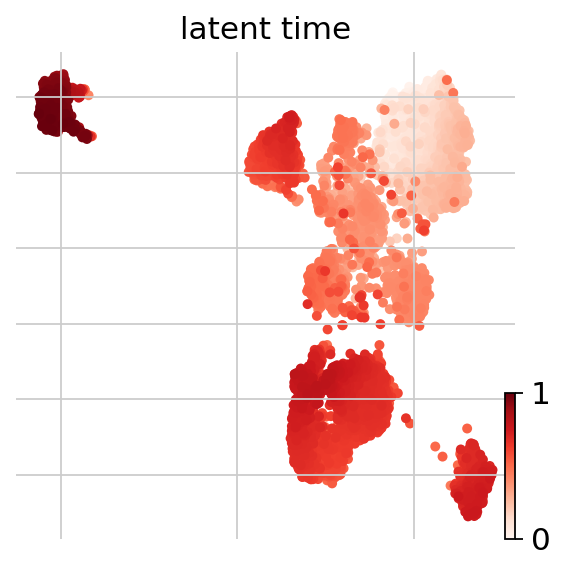

In [18]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='Reds', size=80)

In [19]:
sc.tl.dendrogram(adata,'leiden')
adata.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata, 'leiden', 
                        use_raw=False,
                        method='t-test',n_genes=100)


    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


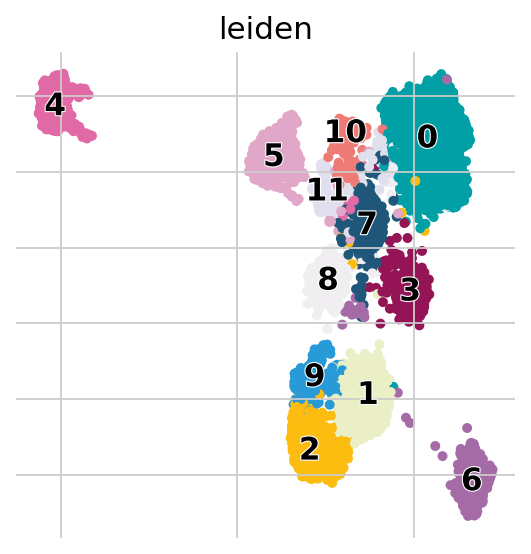

In [20]:
scv.pl.scatter(adata, color='leiden', color_map='Reds', size=80)

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: Retinal stem cells, Photoreceptor cells, P-Photoreceptor cells, etc.


{'mainplot_ax': <AxesSubplot:>,
 'group_extra_ax': <AxesSubplot:>,
 'gene_group_ax': <AxesSubplot:>,
 'size_legend_ax': <AxesSubplot:title={'center':'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot:title={'center':'Mean expression\nin group'}>}

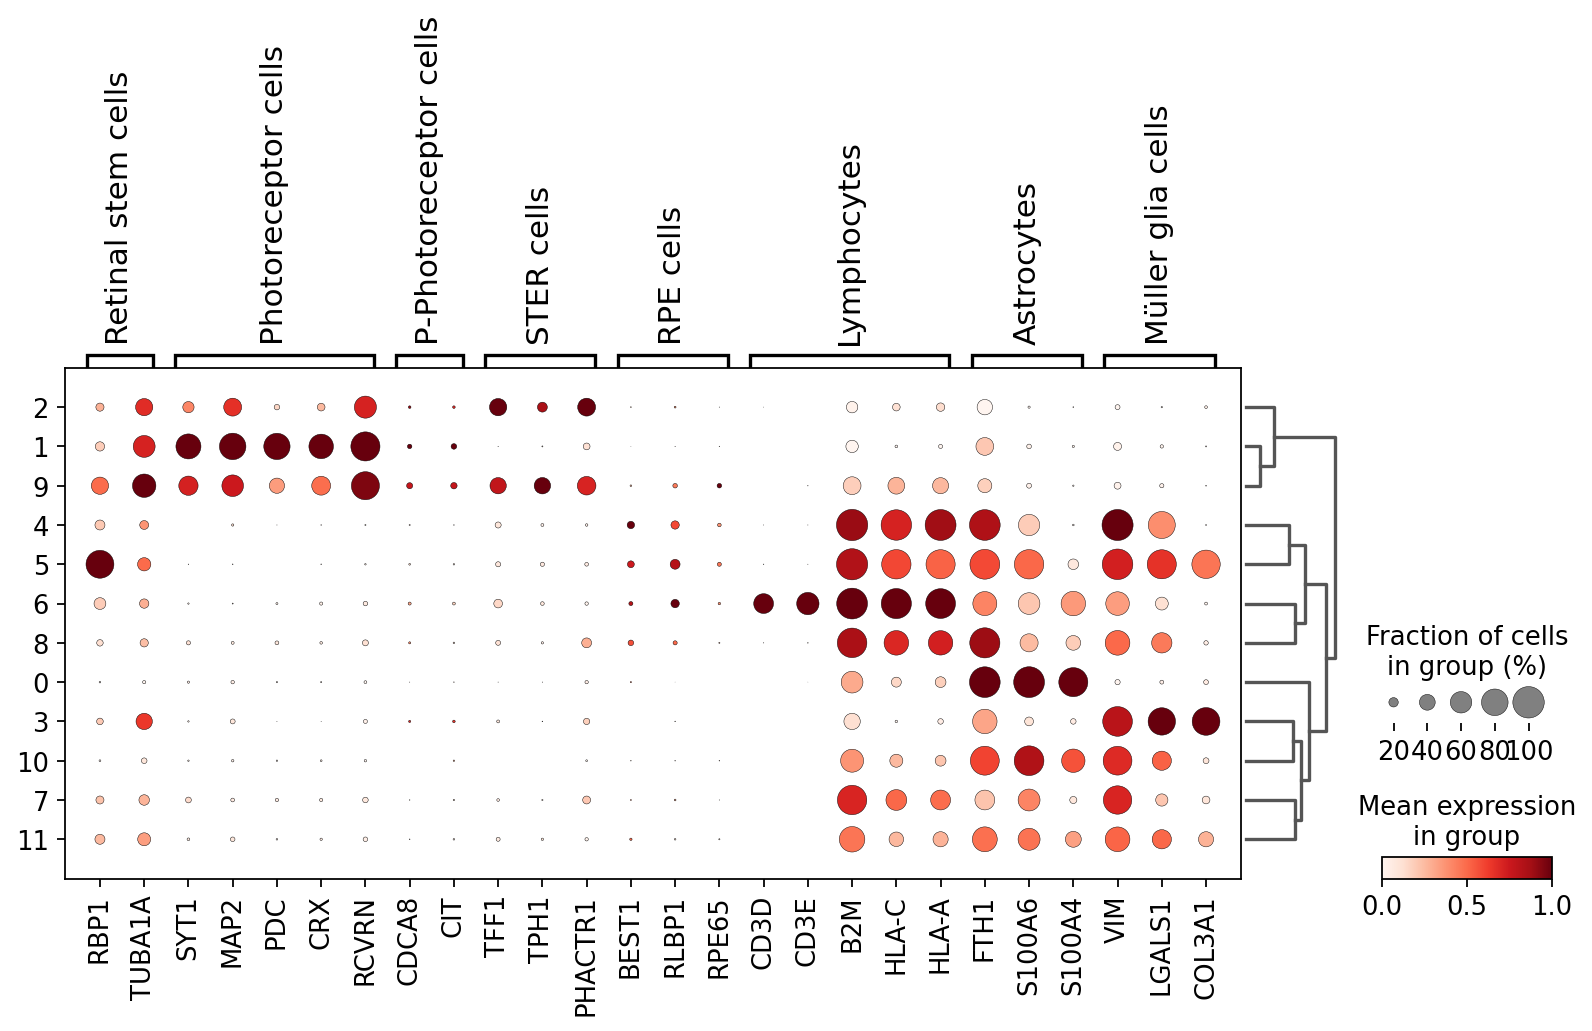

In [21]:
retina_dict={
    'Retinal stem cells':['RBP1','TUBA1A'],
    'Photoreceptor cells':['SYT1','MAP2','PDC','CRX', 'RCVRN',],
    'P-Photoreceptor cells':['CDCA8','CIT',],
    'STER cells':['TFF1','TPH1','PHACTR1'],
    'RPE cells':['BEST1', 'RLBP1', 'RPE65',],
    'Lymphocytes':['CD3D','CD3E','B2M','HLA-C','HLA-A'],
    'Astrocytes':['FTH1','S100A6','S100A4'],
    'Müller glia cells':['VIM','LGALS1','COL3A1'],
}
sc.tl.dendrogram(adata,'leiden')
sc.pl.dotplot(adata, retina_dict, 'leiden', dendrogram=True,standard_scale='var',show=False)
#plt.savefig(current_path+'result_1/retina_celltype.png',dpi=300,bbox_inches='tight')

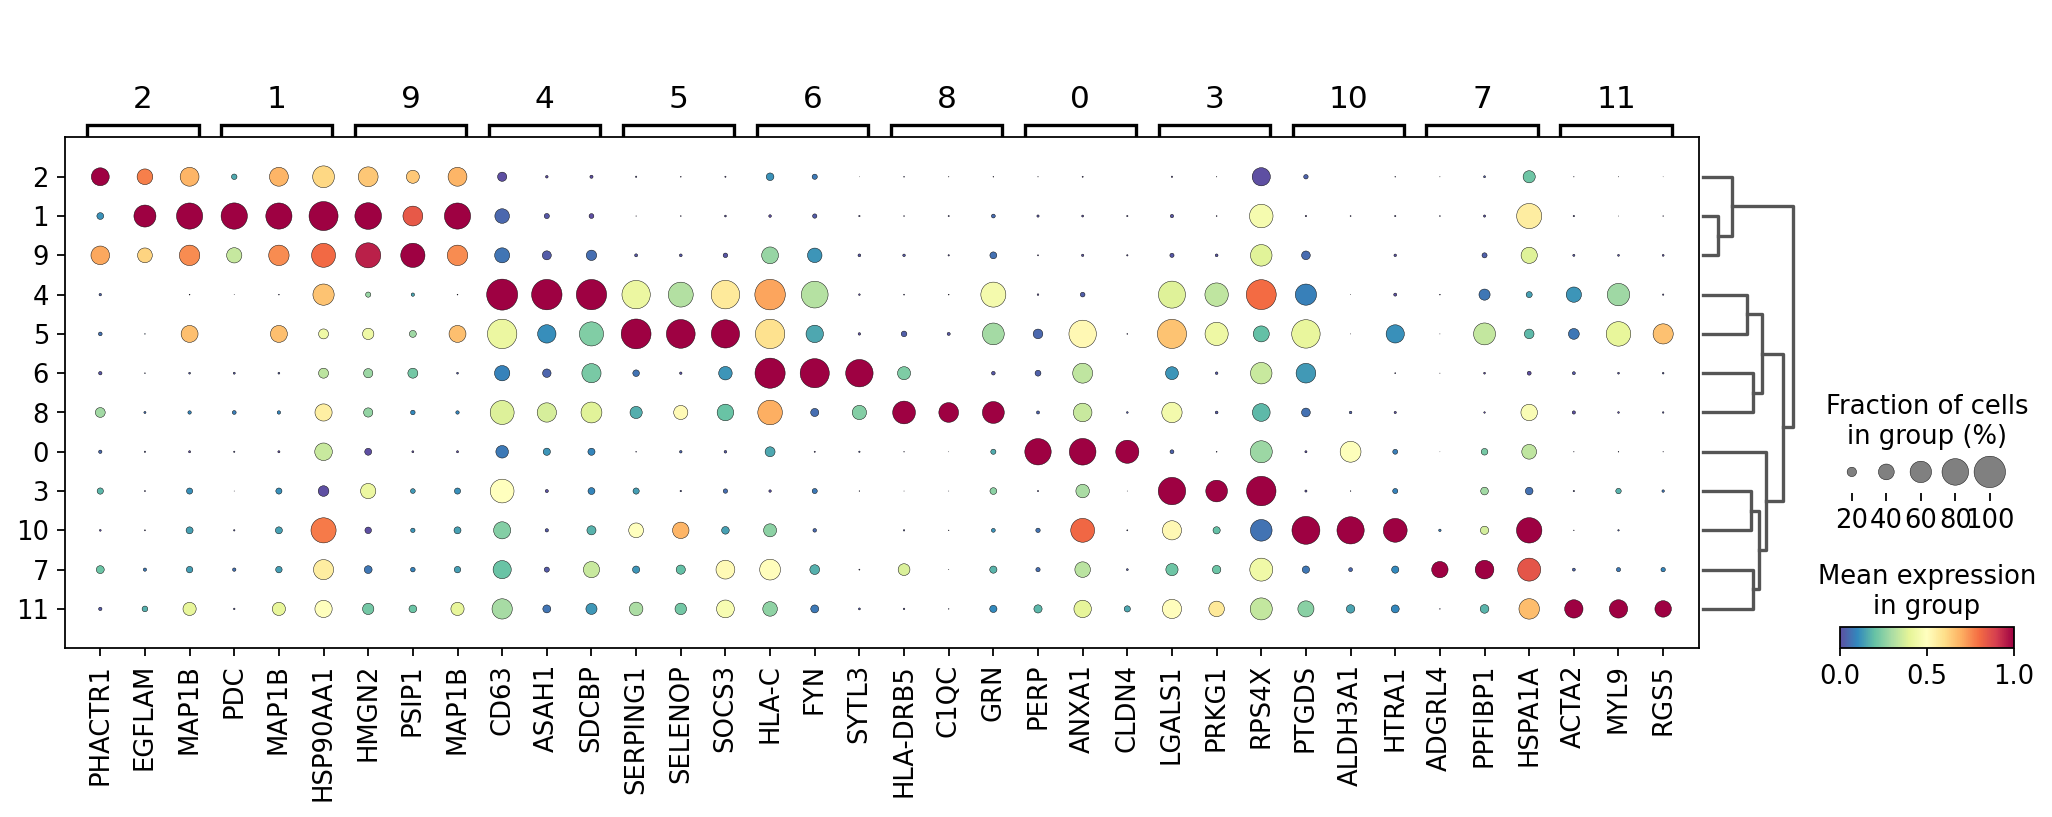

In [22]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

**finished identifying marker genes by COSG**


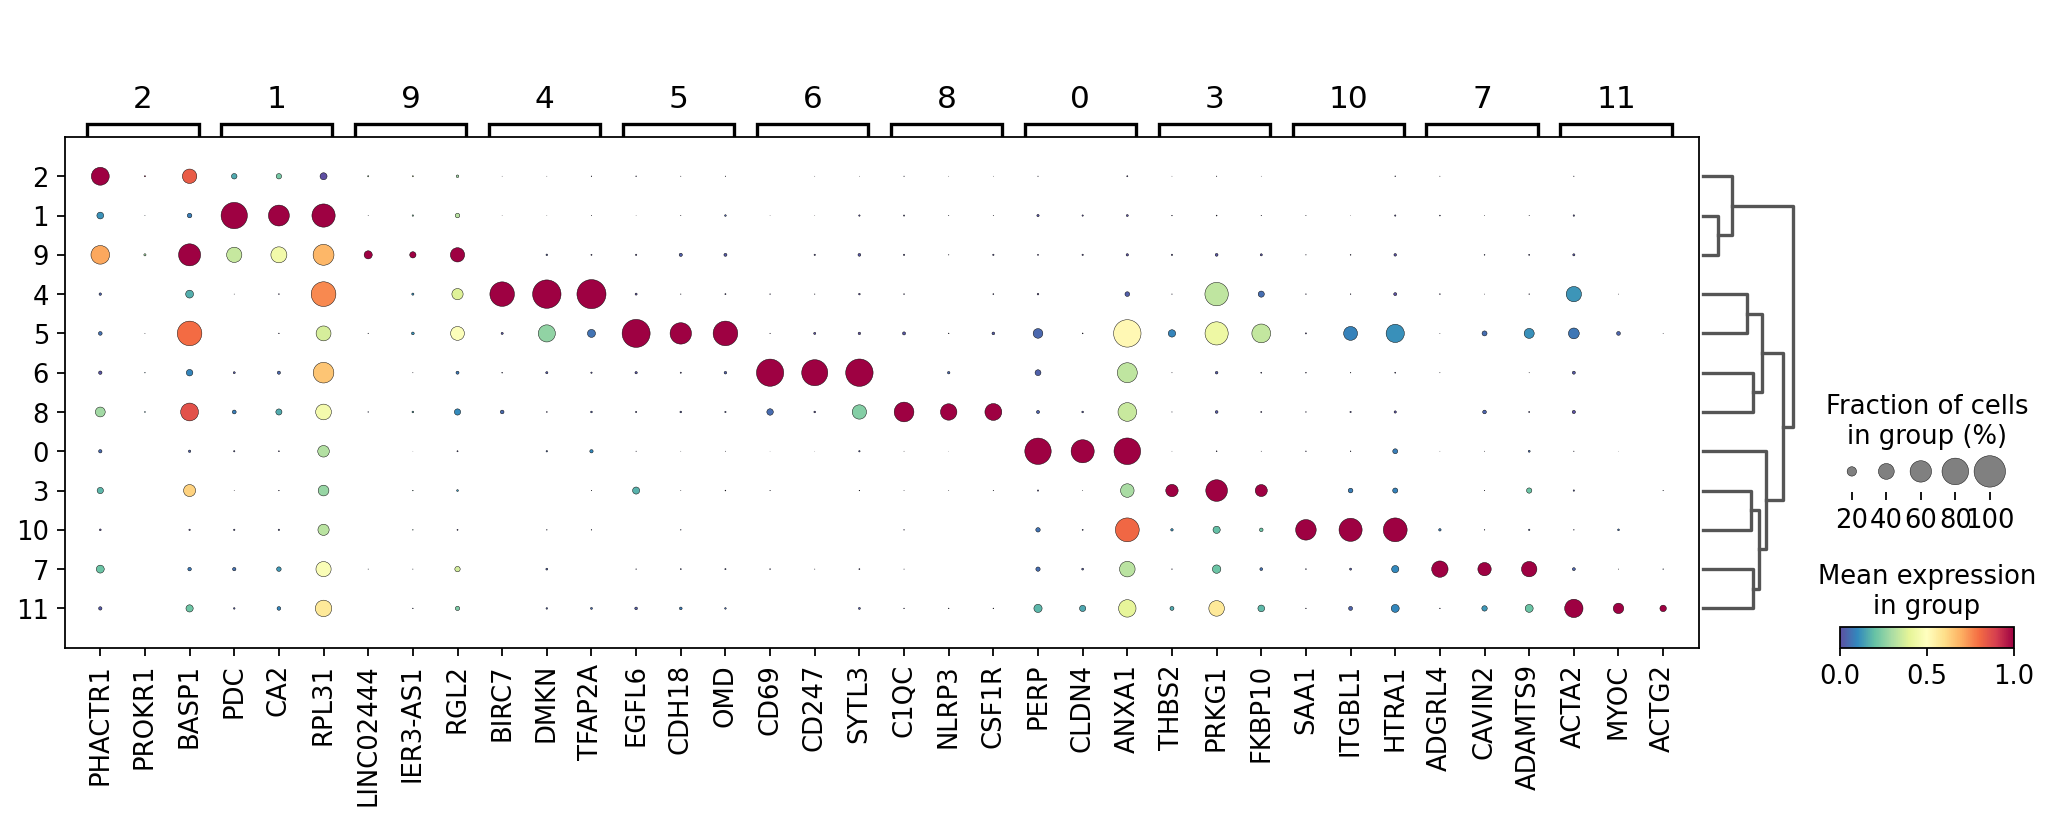

In [23]:
Pyomic.single.cosg(adata, key_added='cosg', groupby='leiden',n_genes_user=10)
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='cosg',
                                standard_scale='var',n_genes=3)

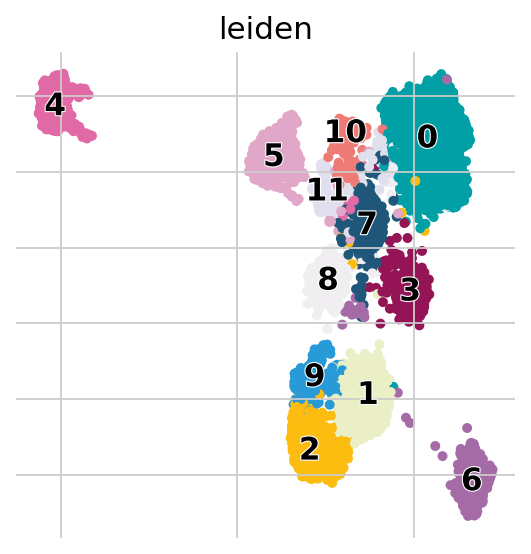

In [24]:
scv.pl.scatter(adata, color='leiden', color_map='Reds', size=80)

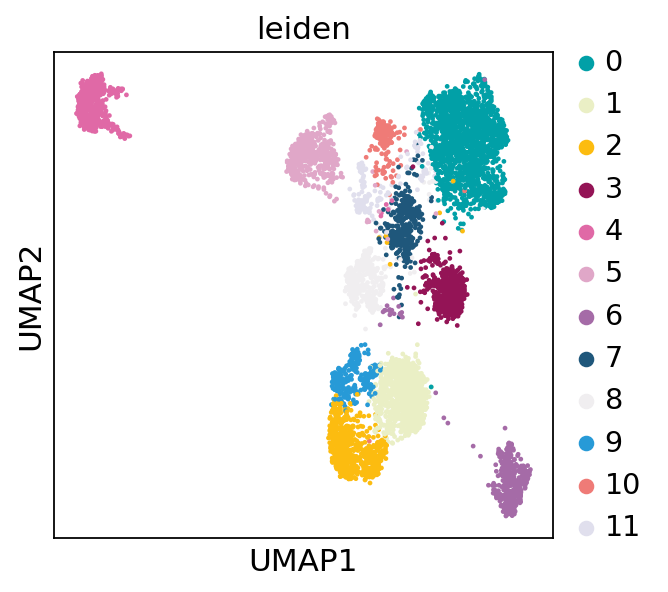

In [25]:
sc.pl.umap(adata,color=['leiden'])

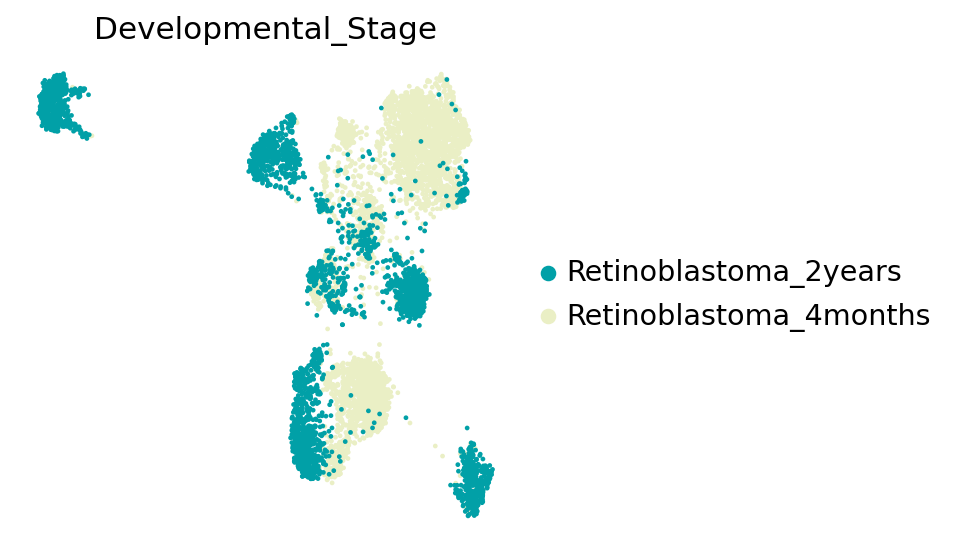

In [26]:

ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['Developmental_Stage'],
    title='Developmental_Stage',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)
plt.savefig('result_4/Developmental_Stage.png',dpi=300,bbox_inches='tight')

In [27]:
adata.obs

initial_size_spliced  initial_size_unspliced  \
AAACCCACAACTCGTA-759                   711                     280   
AAACCCATCAGTGTTG-759                   366                     149   
AAACGAACAGTCAGTT-759                   443                      80   
AAACGAAGTCCCTCAT-759                   285                     140   
AAACGCTAGAAATCCA-759                   192                     302   
...                                    ...                     ...   
TTTCATGCAATCTCGA-762                   320                     159   
TTTGACTAGCCATTGT-762                   330                     402   
TTTGATCCAGCTTCCT-762                   302                     255   
TTTGGTTTCGCTCCTA-762                 11209                   10298   
TTTGTTGCAATCCTTT-762                  2768                    3662   

                      initial_size          Tissue     Developmental_Stage  \
AAACCCACAACTCGTA-759         711.0  Retinoblastoma  Retinoblastoma_4months   
AAACCCATCAGTGTTG-759         366.0  Retinoblastoma  Retinoblastoma_4months   
AAACGAACAGTCAGTT-759         443.0  Retinoblastoma  Retinoblastoma_4months   
AAACGAAGTCCCTCAT-759         285.0  Retinoblastoma  Retinoblastoma_4months   
AAACGCTAGAAATCCA-759         192.0  Retinoblastoma  Retinoblastoma_4months   
...                            ...             ...                     ...   
TTTCATGCAATCTCGA-762         320.0  Retinoblastoma   Retinoblastoma_2years   
TTTGACTAGCCATTGT-762         330.0  Retinoblastoma   Retinoblastoma_2years   
TTTGATCCAGCTTCCT-762         302.0  Retinoblastoma   Retinoblastoma_2years   
TTTGGTTTCGCTCCTA-762       11209.0  Retinoblastoma   Retinoblastoma_2years   
TTTGTTGCAATCCTTT-762        2768.0  Retinoblastoma   Retinoblastoma_2years   

                      n_genes  doublet_score  predicted_doublet  \
AAACCCACAACTCGTA-759      824       0.053665              False   
AAACCCATCAGTGTTG-759      429       0.031600              False   
AAACGAACAGTCAGTT-759      384       0.020057              False   
AAACGAAGTCCCTCAT-759      390       0.009752              False   
AAACGCTAGAAATCCA-759      506       0.110978              False   
...                       ...            ...                ...   
TTTCATGCAATCTCGA-762      447       0.014969              False   
TTTGACTAGCCATTGT-762      723       0.067103              False   
TTTGATCCAGCTTCCT-762      512       0.022693              False   
TTTGGTTTCGCTCCTA-762     6813       0.088000              False   
TTTGTTGCAATCCTTT-762     3066       0.022298              False   

                      n_genes_by_counts  total_counts  ...  balancing_weight  \
AAACCCACAACTCGTA-759                824        1254.0  ...          1.352541   
AAACCCATCAGTGTTG-759                429         666.0  ...          0.804646   
AAACGAACAGTCAGTT-759                384         696.0  ...          1.181992   
AAACGAAGTCCCTCAT-759                390         562.0  ...          0.804646   
AAACGCTAGAAATCCA-759                506         571.0  ...          0.936047   
...                                 ...           ...  ...               ...   
TTTCATGCAATCTCGA-762                447         583.0  ...          1.155589   
TTTGACTAGCCATTGT-762                723         868.0  ...          0.506112   
TTTGATCCAGCTTCCT-762                512         679.0  ...          1.155589   
TTTGGTTTCGCTCCTA-762               6813       26167.0  ...          0.754438   
TTTGTTGCAATCCTTT-762               3066        7788.0  ...          1.823955   

                        n_counts     major_celltype         obs_index_raw  \
AAACCCACAACTCGTA-759 -152.230194  Müller glia cells  AAACCCACAACTCGTA-759   
AAACCCATCAGTGTTG-759 -333.624695  Müller glia cells  AAACCCATCAGTGTTG-759   
AAACGAACAGTCAGTT-759 -402.761047  Müller glia cells  AAACGAACAGTCAGTT-759   
AAACGAAGTCCCTCAT-759 -472.356812  Müller glia cells  AAACGAAGTCCCTCAT-759   
AAACGCTAGAAATCCA-759 -387.764709         Astrocytes  AAACGCTAGAAATCCA-759   
...             

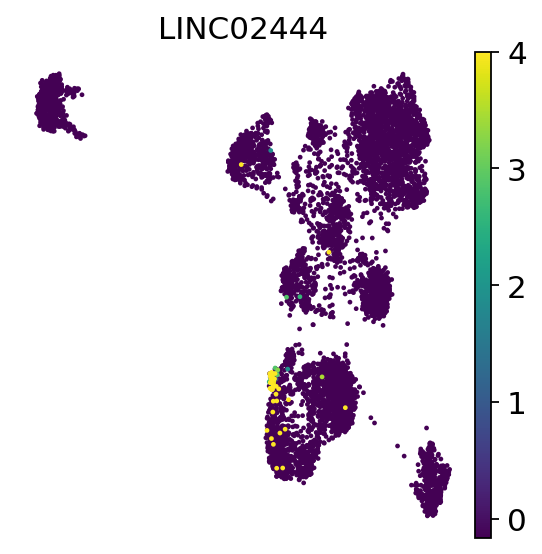

In [28]:

ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['LINC02444'],
    title='LINC02444',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    vmax=4,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)
plt.savefig('result_4/LINC02444.png',dpi=300,bbox_inches='tight')

In [29]:
adata.obs['major_celltype'].unique()

['Müller glia cells', 'Astrocytes', 'Lymphocytes', 'Retinal pigment epithelium (RPE) cells']
Categories (4, object): ['Astrocytes', 'Lymphocytes', 'Müller glia cells', 'Retinal pigment epithelium (RPE) cells']

In [30]:
#adata=adata[~adata.obs['leiden'].isin(['10'])]

In [31]:
# create a dictionary to map cluster to annotation label
#Müller glia cells(MGC)
cluster2annotation = {
     '0': 'Astrocytes CLU+',
     '1': 'fibrous Astrocytes',
     '2': 'Astrocytes PHACTR1+',
     '3': 'MGC-Normal',
     '4': 'Microglial cells',
     '5': 'MGC-Profiled',
     '6': 'T cells',
     '7': 'MGC-Immune',
     '8': 'Dendritic cells',
     '9': 'foot process Astrocytes',
     '10': 'Middle Glial cells',
     '11': 'MGC-Normal',
   


}
adata.obs['major_celltype1'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

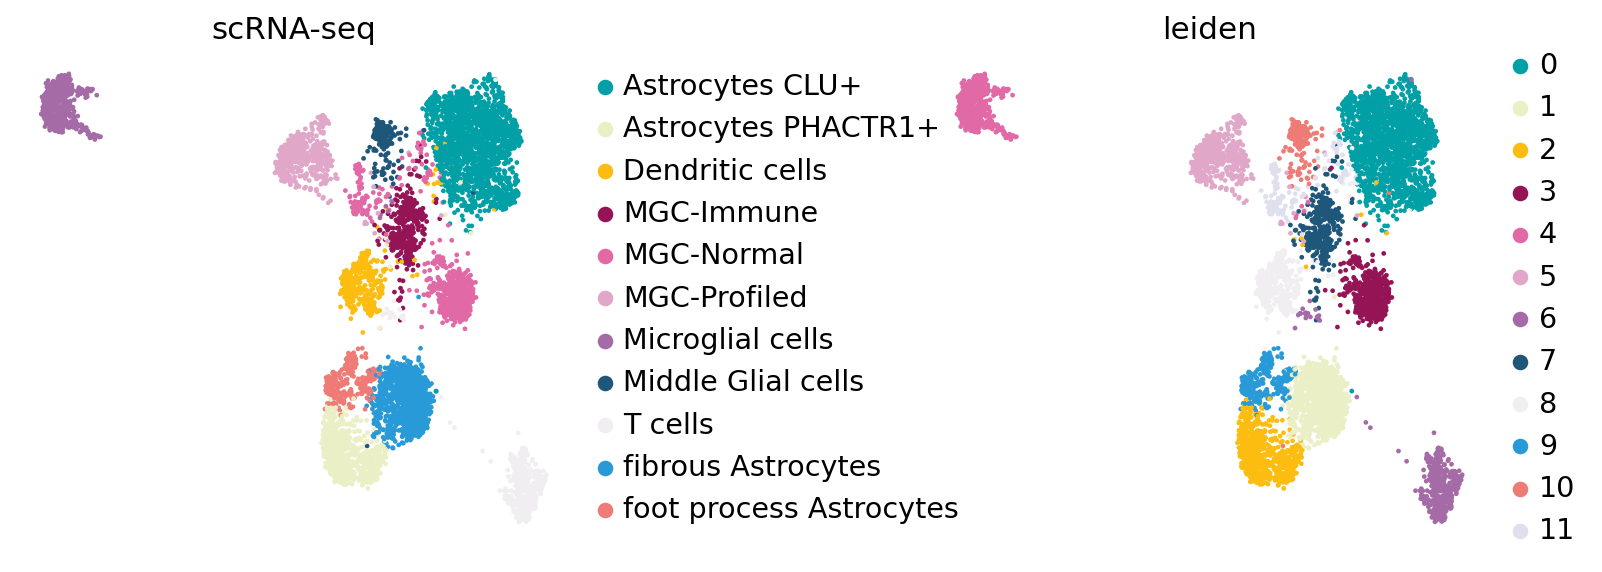

In [32]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['major_celltype1','leiden'],
    title='scRNA-seq',
    frameon=False,
    ncols=3,
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
)

2023-03-28 00:31:47.492247	Running VIA over input data of 6614 (samples) x 100 (features)
2023-03-28 00:31:47.492288	Knngraph has 20 neighbors
2023-03-28 00:31:50.412354	Finished global pruning of 20-knn graph used for clustering at level of 0.15. Kept 43.3 % of edges. 
2023-03-28 00:31:50.434131	Number of connected components used for clustergraph  is 1
2023-03-28 00:31:51.291003	Commencing community detection
2023-03-28 00:31:51.369747	Finished running Leiden algorithm. Found 295 clusters.
2023-03-28 00:31:51.371315	Merging 260 very small clusters (<10)
2023-03-28 00:31:51.373714	Finished detecting communities. Found 35 communities
2023-03-28 00:31:51.374222	Making cluster graph. Global cluster graph pruning level: 0.5
2023-03-28 00:31:51.385801	Graph has 1 connected components before pruning
2023-03-28 00:31:51.387748	Graph has 1 connected components after pruning
2023-03-28 00:31:51.387949	Graph has 1 connected components after reconnecting
2023-03-28 00:31:51.388627	1.1% links tri

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


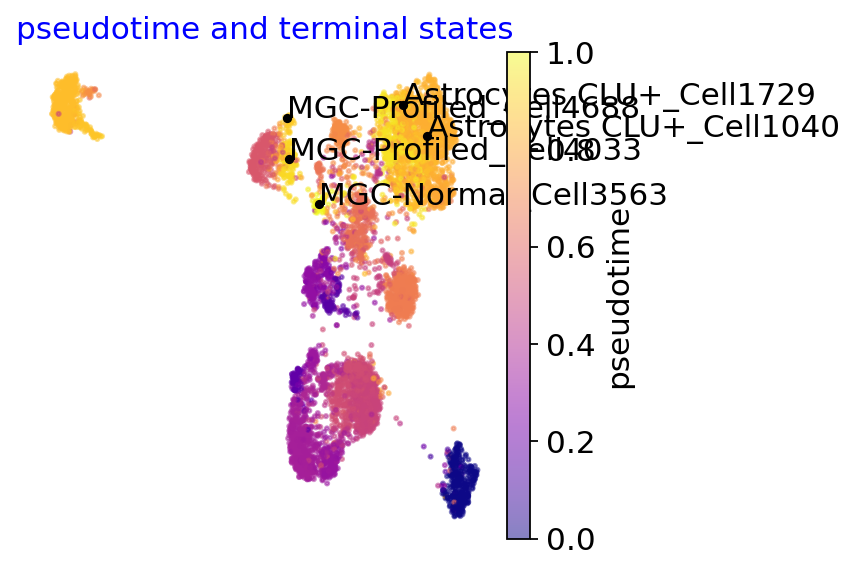

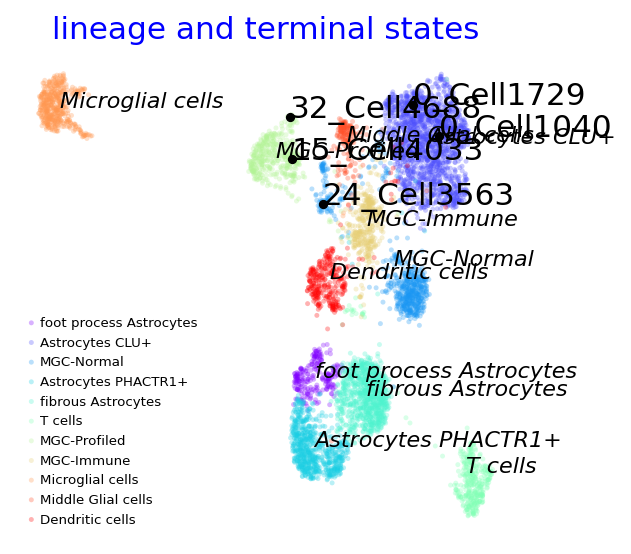

2023-03-28 00:31:59.552960	Time elapsed 10.9 seconds


In [33]:
jac_std_global = 0.15 #(smaller values increase granularity of clusters)
n_pcs = 100
knn = 20
cluster_graph_pruning_std = 0.5 #(smaller values remove more edges in the cluster graph)
v0_toobig = .3 #(clusters that form more than 30% of entire population will be re-clustered)
root = None # No user-defined guidance for finding initial state [63] is a suitable root cell index
dataset = ''
random_seed = 42
velo_weight=0.5 #weight given to velocity matrix from scvelo. 1-velo_weight is assigned to gene-gene kernel
embedding = adata.obsm['X_umap'][:, 0:2]
true_label = adata.obs['major_celltype1'].tolist()
velocity_matrix=adata.layers['velocity']
gene_matrix=adata.X
pca_loadings = adata.varm['PCs'] # this is optional and offers slight adjustment of the locations of cells based on velocity

#impute genes we want to use in gene-trends later
#gene_list_magic_short = ['Sst','Ins1','Ins2','Gcg','Ghrl']
#df_ = pd.DataFrame(adata.X.todense())
#df_.columns = [i for i in adata.var_names]
#df_ = df_[gene_list_magic_short]


v0 = via.VIA(adata.obsm['X_pca'][:, 0:n_pcs], true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
             too_big_factor=v0_toobig, root_user=root, dataset=dataset, random_seed=random_seed,
           is_coarse=True, preserve_disconnected=True, pseudotime_threshold_TS=50,
             cluster_graph_pruning_std=cluster_graph_pruning_std,
             piegraph_arrow_head_width=0.15,embedding = embedding,
             piegraph_edgeweight_scalingfactor=2.5, velocity_matrix=velocity_matrix,
                    gene_matrix=gene_matrix, velo_weight=velo_weight,  edgebundle_pruning_twice=False, edgebundle_pruning=0.15, pca_loadings = adata.varm['PCs']) # pca_loadings is optional #edge_bundling_twice = True would remove more of the edges
v0.run_VIA()

Text(0.5, 1.0, 'Pseudotime')

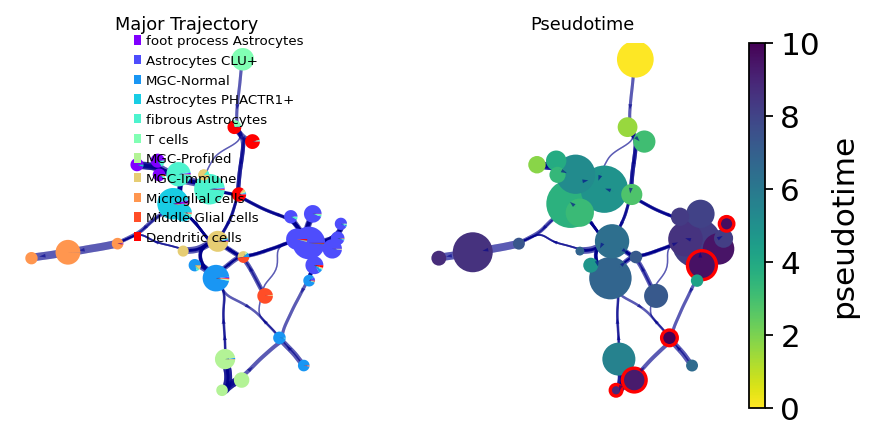

In [34]:
fig, ax, ax1 = via.draw_piechart_graph(via_object=v0,dpi=80,
                                       ax_text=False,fontsize=4)
fig.set_size_inches(6,3)
ax.set_title('Major Trajectory',fontsize=8)
#ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0.,fontsize=8)
ax1.set_title('Pseudotime',fontsize=8)

In [35]:
adata.obs['major_celltype1'].cat.categories

Index(['Astrocytes CLU+', 'Astrocytes PHACTR1+', 'Dendritic cells',
       'MGC-Immune', 'MGC-Normal', 'MGC-Profiled', 'Microglial cells',
       'Middle Glial cells', 'T cells', 'fibrous Astrocytes',
       'foot process Astrocytes'],
      dtype='object')

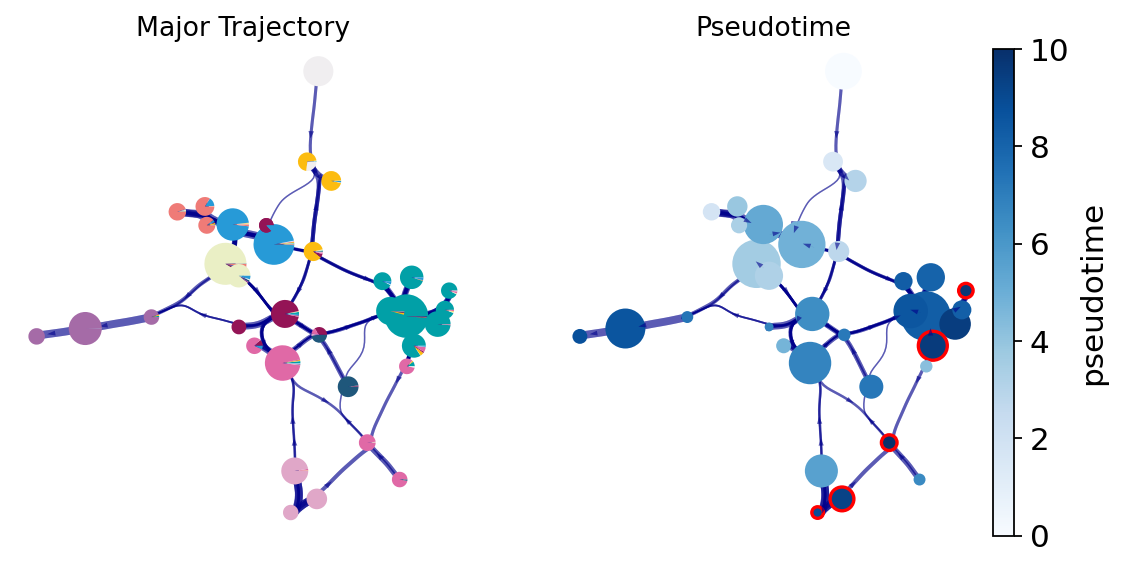

In [36]:
fig, ax, ax1 = draw_piechart_graph(adata=adata,clusters='major_celltype1',
                                   via_object=v0,cmap='Blues',dpi=80,
                                   show_legend=False,ax_text=False,fontsize=4)
fig.set_size_inches(8,4)
ax.set_title('Major Trajectory',fontsize=12)
#ax.legend(bbox_to_anchor=(0.5, 0), loc='upper center', borderaxespad=0.,fontsize=8)
ax1.set_title('Pseudotime',fontsize=12)
plt.rcParams['axes.facecolor']='snow'

plt.savefig('result_4/P_tr.png',dpi=300,bbox_inches='tight')

<AxesSubplot:title={'center':'scATAC-seq'}, xlabel='X_umap1', ylabel='X_umap2'>

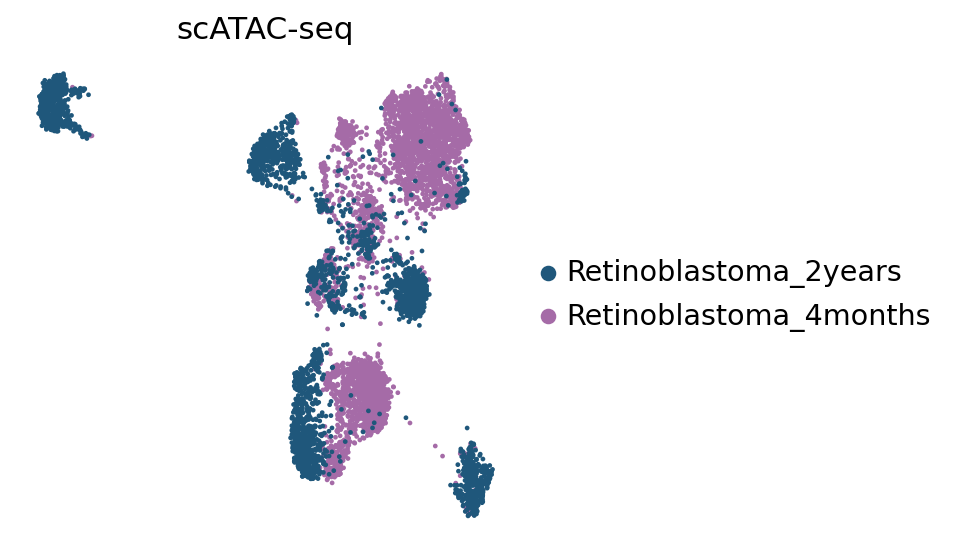

In [37]:
sc.pl.embedding(
    adata,
    basis="X_umap",
    color=['Developmental_Stage'],
    title='scATAC-seq',
    frameon=False,
    ncols=1,
    #save='_figure1_celltype.png',
    #return_fig=True,
    #wspace=0.5,
    show=False,
    
    palette=sc_color[11:],
)

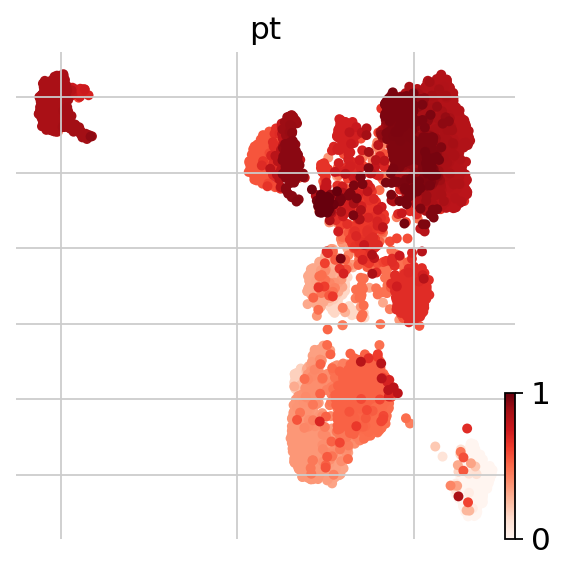

In [38]:
adata.obs['pt']=v0.single_cell_pt_markov
scv.pl.scatter(adata, color='pt', color_map='Reds', size=80)

In [39]:
from cellrank.tl.kernels import PseudotimeKernel
ptk=PseudotimeKernel(adata,time_key='pt')

In [40]:
ptk.compute_transition_matrix()
ptk.compute_projection(basis='umap')

Computing transition matrix based on `pt`


100%|██████████| 6614/6614 [00:01<00:00, 4088.09cell/s]


    Finish (0:00:05)
Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:01)


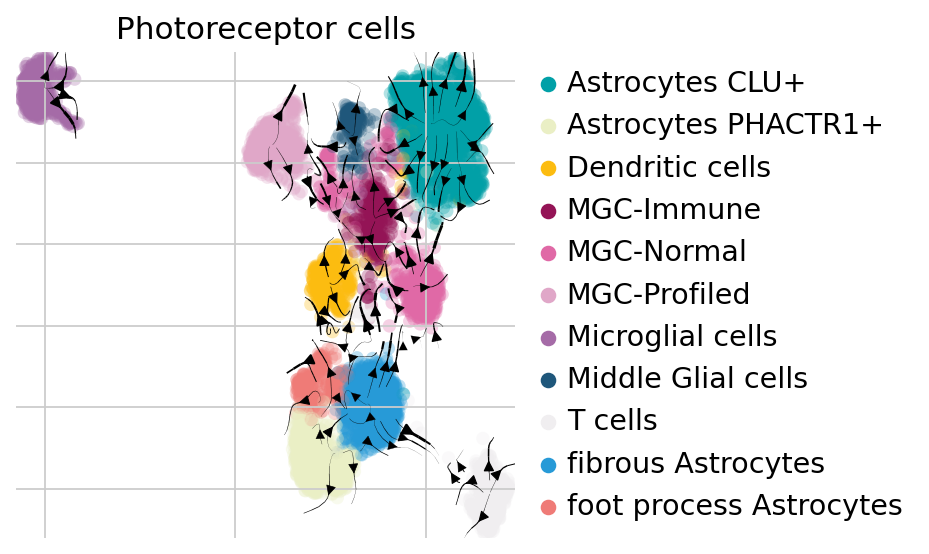

In [41]:
scv.pl.velocity_embedding_stream(adata, vkey='T_fwd',color=['major_celltype1',],
                                 title='Photoreceptor cells',
                                 legend_loc='right margin',
                                legend_align_text='y',show=False,)
plt.savefig('result_4/P_celltype.png',dpi=300,bbox_inches='tight')

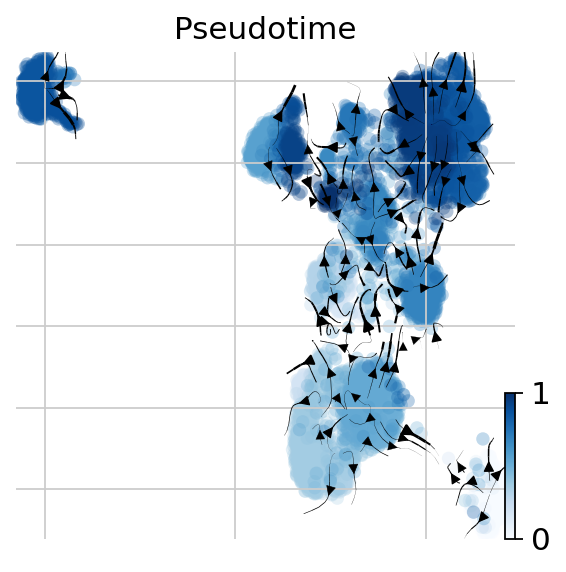

In [42]:
scv.pl.velocity_embedding_stream(adata, vkey='T_fwd',color=['pt',],
                                 title='Pseudotime',
                                 legend_loc='right margin',cmap='Blues',
                                legend_align_text='y',show=False,)
plt.savefig('result_4/P_pt.png',dpi=300,bbox_inches='tight')

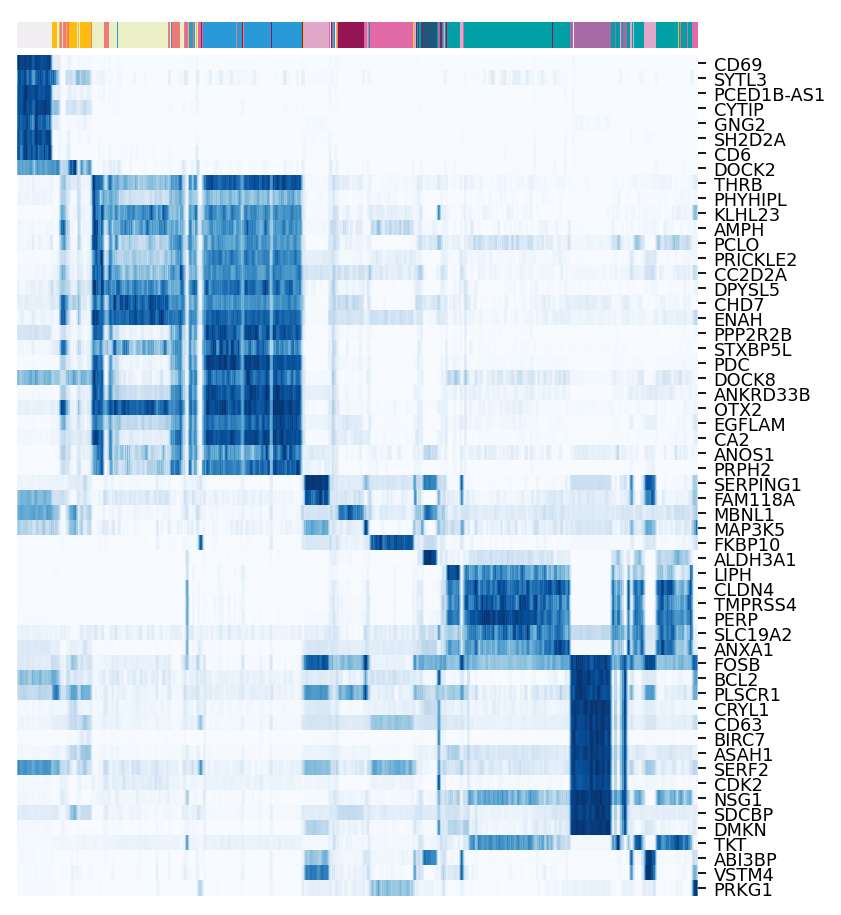

In [43]:
top_genes_neg = adata.var.loc[adata.var['fit_likelihood']>0.25].index
a=scv.pl.heatmap(adata, var_names=top_genes_neg, sortby='pt', col_color=['major_celltype1'],
               n_convolve=30,figsize=(6,6),yticklabels=True,show=False,color_map='Blues')
a.ax_heatmap.yaxis.set_tick_params(labelsize=8)
a.ax_col_colors.yaxis.set_ticks([1.5],['major_celltype1'],ha='left')
a.ax_col_colors.yaxis.tick_right()
labels=a.ax_col_colors.yaxis.get_ticklabels()
plt.setp(labels, fontsize=8)
plt.savefig('result_4/P_time_gene.png',dpi=300,bbox_inches='tight')

In [44]:
adata=adata[:,[i for i in adata.var.index if 'RPS' not in i]]

In [45]:
adata=adata[:,[i for i in adata.var.index if 'RPL' not in i]]

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_major_celltype1']`


/home/leihu/pyomic/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


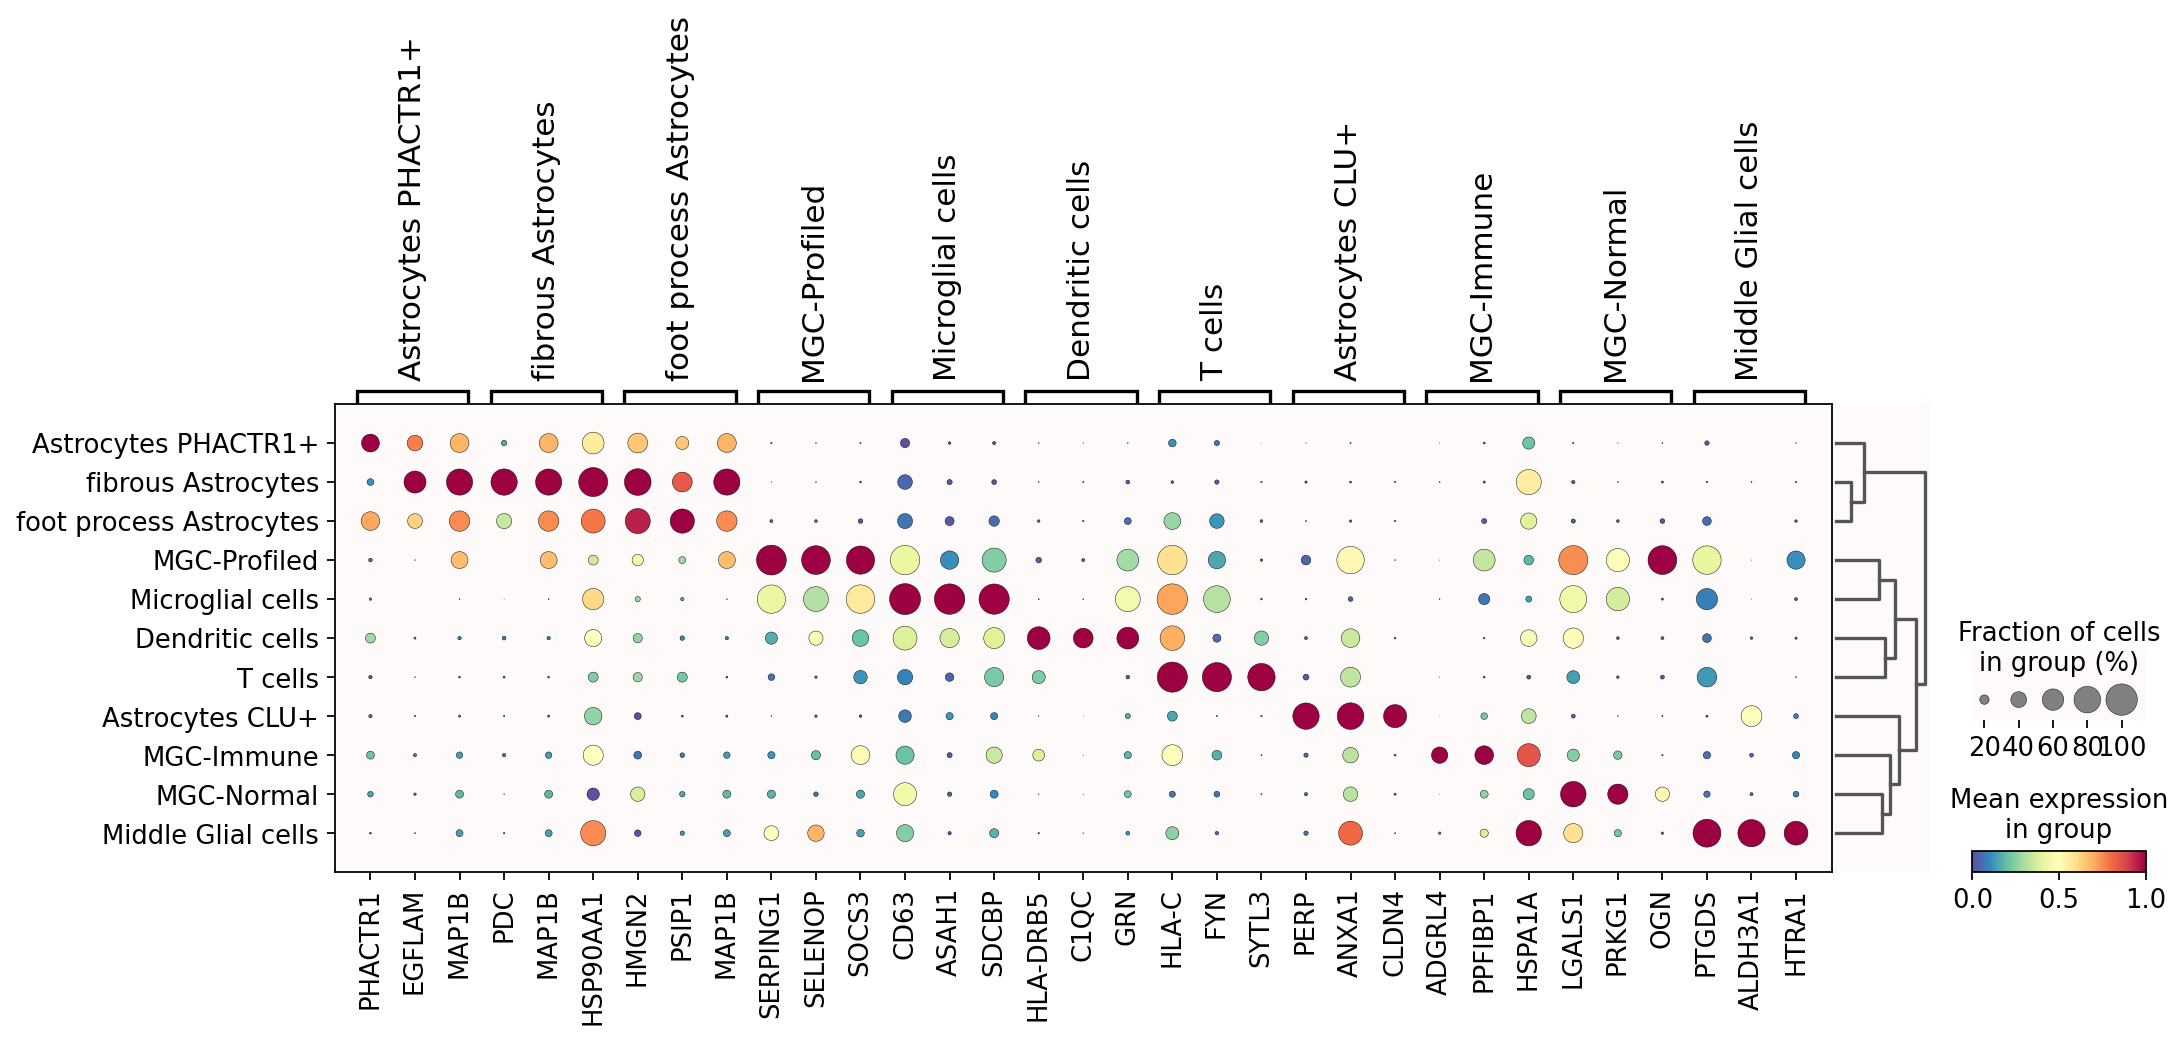

In [46]:
sc.tl.dendrogram(adata,'major_celltype1')
sc.tl.rank_genes_groups(adata, 'major_celltype1', method='t-test',use_raw=False,n_genes=50)
sc.pl.rank_genes_groups_dotplot(adata,groupby='major_celltype1',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=3)

In [47]:
ax

<AxesSubplot:title={'center':'Major Trajectory'}>

In [48]:
ax['groupby_ax'].get_xticklabels()

TypeError: 'AxesSubplot' object is not subscriptable

In [ ]:
ax=sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, use_raw=False, 
                                swap_axes=True, standard_scale='obs',
                                cmap='Blues',  figsize=(6,5), show=False)
ax['heatmap_ax'].set_yticklabels(ax['heatmap_ax'].get_yticklabels(),fontsize=8)
ax['groupby_ax'].set_xticklabels([])
plt.savefig('result_4/P_marker.png',dpi=300,bbox_inches='tight')

In [ ]:
target_dict_all={}
for ad,name in zip([adata],['RNA']):
    celltype=[(i, 'O') for i in ad.uns['rank_genes_groups']['names'].dtype.names]
    target_dict={}
    target_pd=pd.DataFrame()
    for i in range(len(celltype)):
        cellmarker=[]
        for k in range(50):
            #rank_genes_groups
            cellmarker.append(ad.uns['rank_genes_groups']['names'][k][i])
        #print(cellmarker[0])
        target_pd[celltype[i][0]]=cellmarker
        #ret_target=list(set(cellmarker) & set(rnk_gene))
        target_dict[celltype[i][0]]=cellmarker

    target_dict.keys(),len(cellmarker)
    target_dict_all[name]=target_dict

In [ ]:
adata_raw = adata.raw.to_adata()
adata_raw

In [ ]:
adata

In [ ]:
adata.var

In [ ]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              )

scv.pl.scatter(adata_raw, ['FAM118A',], color='major_celltype',
               ylabel='MGC-profiled cells', show=False,figsize=(3,3),
               **kwargs)
plt.savefig('result_4/P_v_{}.png'.format(str(['FAM118A',])),dpi=300,bbox_inches='tight')

In [ ]:
scv.pl.scatter(adata, ['PDGFD','SERPING1'], color='major_celltype1',
               ylabel='MGC-profiled cells', show=False,figsize=(3,3),
               **kwargs)
plt.savefig('result_4/P1_v_{}.png'.format(str(['PDGFD','SERPING1'])),dpi=300,bbox_inches='tight')

In [ ]:
scv.pl.scatter(adata, ['FAM118A','FOSB'], color='major_celltype1',
               ylabel='MGC-profiled cells', show=False,figsize=(3,3),
               **kwargs)
plt.savefig('result_4/P1_v_{}.png'.format(str(['FAM118A','FOSB'])),dpi=300,bbox_inches='tight')

In [ ]:
df_ = pd.DataFrame(adata.X)
df_.columns = [i for i in adata.var_names]

gene_list_magic = ['PDGFD','SERPING1']
plt.rcParams['axes.facecolor']='snow'

df_magic = v0.do_impute(df_, magic_steps=3, gene_list=gene_list_magic)
df_magic['parc'] = v0.labels
df_magic_cluster = df_magic.groupby('parc', as_index=True).mean()

fig, axs = via.draw_clustergraph(via_object=v0, type_data='gene', 
                                 gene_exp=df_magic_cluster, gene_list=gene_list_magic, arrow_head=0.1)
fig.set_size_inches(6,3)
fig.savefig('result_4/P_{}.png'.format(str(gene_list_magic)),dpi=300,bbox_inches='tight')

In [ ]:
df_ = pd.DataFrame(adata.X)
df_.columns = [i for i in adata.var_names]

gene_list_magic = ['FAM118A','FOSB']
plt.rcParams['axes.facecolor']='snow'

df_magic = v0.do_impute(df_, magic_steps=3, gene_list=gene_list_magic)
df_magic['parc'] = v0.labels
df_magic_cluster = df_magic.groupby('parc', as_index=True).mean()

fig, axs = via.draw_clustergraph(via_object=v0, type_data='gene', 
                                 gene_exp=df_magic_cluster, gene_list=gene_list_magic, arrow_head=0.1)
fig.set_size_inches(6,3)
fig.savefig('result_4/P_{}.png'.format(str(gene_list_magic)),dpi=300,bbox_inches='tight')

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from scipy import sparse
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sys.executable

In [ ]:
#neuron是我们注释好的视神经数据
adata.obs['major_celltype1'].unique()

In [ ]:
adata1=sc.read('data/photo.h5ad')
adata1

In [ ]:
adata1=adata1[adata1.obs['major_celltype1']=='STER cells']
adata1

In [ ]:
import anndata
adata_new=anndata.concat([adata,adata1],merge='same')
adata_new

In [ ]:
adata_new

In [ ]:
adata_new.obs['major_celltype1'].unique()

In [ ]:
#矩阵
adata_raw=adata_new.raw.to_adata()[adata_new.obs.index]
sc.pp.filter_cells(adata_raw, min_genes=200)
sc.pp.filter_genes(adata_raw, min_cells=3)
adata_raw=anndata.AnnData(adata_raw.X,obs=pd.DataFrame(index=adata_raw.obs.index),
                          var=pd.DataFrame(index=adata_raw.var.index))
adata_raw.write_h5ad('neuron_raw.h5ad',compression='gzip')
adata_raw.to_df().T.to_csv('neuron_counts.tsv',sep='\t')
adata_raw


In [ ]:
adata_raw

In [ ]:
#由于文件太大了我们压缩一下，CellPhoneDB在服务器上，我们上传到服务器后再解压缩进行分析
!gzip neuron_counts.tsv

In [ ]:
#meta导出
df_meta = pd.DataFrame(data={'Cell':list(adata_new[adata_raw.obs.index].obs.index),
                             'cell_type':[ i for i in adata_new[adata_raw.obs.index].obs['major_celltype1']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('neuron_meta.tsv', sep = '\t')

In [ ]:
!pip install --quiet cellphonedb

In [ ]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

In [ ]:
!cellphonedb method statistical_analysis \
neuron_meta.tsv \
neuron_counts.tsv \
--output-path data/analysis/rb_analysis/neuron_2 \
--counts-data hgnc_symbol

In [ ]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scvi
print('scvi(Ver): ',scvi.__version__)
import gseapy as gp
print('gseapy(Ver): ',gp.__version__)

#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

In [ ]:
sig_means=pd.read_csv('neuron_2/significant_means.txt',sep='\t')
sig_means.head()

In [ ]:
de=pd.read_csv('neuron_2/deconvoluted.txt',sep='\t')
de.columns[:]

In [ ]:
import networkx as nx
G=nx.Graph()
test=sig_means.loc[:,sig_means.columns.str.contains('\|')].sum()
for i in test.index:
    if test.loc[i]!=0:
        a=i.split('|')
        G.add_edge(a[0],a[1],weight=test.loc[i])
nodes=[]
G_degree=dict(G.degree(G.nodes()))


G_nodes_dict={}
links = []
for i in G.edges:
    if i[0] not in G_nodes_dict.keys():
        G_nodes_dict[i[0]]=0
    if i[1] not in G_nodes_dict.keys():
        G_nodes_dict[i[1]]=0
    links.append({"source": i[0], "target": i[1]})
    weight=G.get_edge_data(i[0],i[1])['weight']
    G_nodes_dict[i[0]]+=weight
    G_nodes_dict[i[1]]+=weight

In [ ]:
inter_week_dict={} 

#sig_means=pd.read_csv(current_path+'data/analysis4/cellphonedb/significant_means.txt',sep='\t')
#sig_means.head()
#de=pd.read_csv(current_path+'data/analysis4/cellphonedb/deconvoluted.txt',sep='\t')
#de.columns[:]
sig_means1=sig_means.copy()
sig_means1.set_index(sig_means1.columns[1],inplace=True)
sig_means1.head()
pvalue=pd.read_csv('neuron_2/pvalues.txt',sep='\t')
pvalue.set_index(pvalue.columns[1],inplace=True)
p=pvalue.loc[:,pvalue.columns.str.contains('')]
p.head()
exp=sig_means1.loc[:,sig_means1.columns.str.contains('\|')]
exp.head()

plot_data3=pd.DataFrame(columns=['Pair','means','p-value','Type'])
p_pair=exp.columns.tolist()[:]
for i in list(set(exp.index.tolist())):
    plot_data4=pd.DataFrame()
    if len(exp.loc[i].shape)>=2:
        goal_pd=exp.loc[i,p_pair].iloc[0]
    else:
        goal_pd=exp.loc[i,p_pair]
    if len(p.loc[i].shape)>=2:
        goal_p_pd=p.loc[i,p_pair].iloc[0]
    else:
        goal_p_pd=p.loc[i,p_pair]

    if goal_pd.fillna(0).sum()==0:
        continue
    plot_data4['Pair']=[j for j in [i]*len(p_pair)]
    plot_data4['means']=goal_pd.values
    plot_data4['p-value']=-np.log10(goal_p_pd.values.astype('float'))+0.3
    plot_data4['Type']=p_pair

    plot_data3=pd.concat([plot_data3,plot_data4])
plot_data3=plot_data3.fillna(0)

plot_data3['means']=np.log2(plot_data3['means'])
plot_data3=plot_data3.replace(float('inf'),3)
plot_data3=plot_data3.replace(float('-inf'),-3)
plot_data3.head()

In [ ]:
!pip install python-dotplot

In [ ]:
import dotplot
import dotplot.utils
new_keys = {'item_key': 'Pair','group_key': 'Type','sizes_key': 'p-value','color_key': 'means'}
dp_week_EB_dict= dotplot.DotPlot.parse_from_tidy_data(plot_data3.loc[((plot_data3['Type'].str.contains('STER cells\|'))&(plot_data3['p-value']>1))], **new_keys)
    
week_data_dict=dp_week_EB_dict.size_data
week_data_dict.head()

In [ ]:
s=sns.clustermap(week_data_dict,row_cluster=True,col_cluster=False,
                yticklabels=True,figsize=(2,2),
               cmap='vlag',cbar_kws={'shrink': 0.5},vmin=-3,vmax=3)

In [ ]:
ylabel=[i.get_text() for i in s.ax_heatmap.get_yticklabels()]
ylabels=[i for i in ylabel  if len(i)<20]
ylabels

In [ ]:
fig,ax=plt.subplots(figsize=(3,8))
a=sns.heatmap(week_data_dict.loc[ylabels],yticklabels=True,xticklabels=True,
                square=False,cmap='Blues',cbar_kws={'shrink': 0.5},vmin=-3,vmax=3,ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8)
a.set_yticklabels(a.get_yticklabels(), fontsize=8)

xlabs=ax.get_xticklabels()
ax.set_xticklabels(xlabs,fontsize=8)
ylabs=ax.get_yticklabels()
ax.set_yticklabels(ylabs,fontsize=8)

[i.set_text(i.get_text().split('|')[1].replace('Lym_Neg_','').replace('Macrophage/NEUT','Macro').replace('p-value_','')) for i in xlabs]
ax.set_xticklabels(xlabs,fontsize=8)

[i.set_text(i.get_text()) for i in ylabs]
ax.set_yticklabels(ylabs,fontsize=8)
for i in range(len(xlabs)):
    if i%1==0:
        ax.axvline(x=i, ymin=-1, ymax=10,color='black',linestyle="--")
#ax.tick_params(axis='both',colors=type_color_rna['EVT'], which='both')
ax.set_ylabel('')
ax.set_title('STER as Ligand',fontsize=10)
fig.savefig('result_4/ster_cell.png',dpi=300,bbox_inches='tight')

In [ ]:

ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color='EFNB2',
    title='EFNB2',
    frameon=False,
    ncols=3,
    color_map='Blues',
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
    vmax=3,
)
plt.savefig('result_4/EFNB2.png',dpi=300,bbox_inches='tight')

In [ ]:
ax=sc.pl.embedding(
    adata,
    basis="X_umap",
    color='EPHB2',
    title='EPHB2',
    frameon=False,
    ncols=3,
    color_map='Blues',
    #save='_figure1_celltype.png',
    return_fig=True,
    wspace=0.5,
    show=False,
    palette=sc_color[::-1][9:],
    vmax=3,
)
plt.savefig('result_4/EFHB2.png',dpi=300,bbox_inches='tight')